In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split


## 1. task comprehension
The goal of this task is to choose and design a suitable recommendation model as there are multiple recommendation methods, and implement this model to make recommendations. Besides, we regard this recommendation problem as two subtasks, one is to collect multiple recommended properties for a certain property, and the other is to rank these recommended properties as there should be a order for webpage display.

## 2. different approaches and design decision
Use KD tree to get ranking data and input this data into LGBMRanker model training as prediction target to predict top k recommendations with ranks. 

## 3. model construction


### train KD tree for ranking data

#### load data

In [2]:
def load_data(df_file):
    df = pd.read_csv(df_file)
    
    return df


#### standardize data

In [3]:
def standardize_data(df, train_cols, key_col):
    standard_scalar = preprocessing.StandardScaler()
    df_standard = pd.DataFrame(standard_scalar.fit_transform(df[train_cols]), index=df[train_cols].index,columns=train_cols)
    df_standard[key_col] = df[key_col]
    
    return df_standard


#### KD tree Model training

In [4]:
def KD_model_training(df, leaf_size):
    tree = KDTree(df, leaf_size=leaf_size)
    
    return tree


#### get top 10 recommendations for each property with KD tree Model

In [5]:
# get top k recommendations for a single listing_id
def get_top_recommendations_without_rank(row_id, k, data, tree) -> pd.DataFrame:
    row = data.iloc[row_id]
    row = pd.DataFrame([row])

    dist, idx = tree.query(row, k=k+1)
    
    idx = idx[0].tolist()
    if row_id in idx:
        idx.remove(row_id)
    else: 
        idx.pop()
    df_result = data.iloc[idx]

    # Return the dataset with the k recommendations
    return df_result


In [6]:
# get top k recommendations for all listing_id in train_data
def get_top_recommendation_KD(k, data, model, key_col, train_cols):
    df_rank = pd.DataFrame()

    for i in range(data.shape[0]):
        row_recommendations = get_top_recommendations_without_rank(i, k=k, data=data, tree=model)

        row_rank = data[key_col+train_cols].iloc[row_recommendations.index.tolist()]
        row_rank['query_listing_id'] = data.iloc[i]['listing_id']

        row_rank = row_rank.reset_index().reset_index()
        row_rank['level_0'] = row_rank['level_0'].apply(lambda x: x+1)
        row_rank.rename(columns={'level_0': 'rank', 'index':'rec_index'},inplace=True)

        df_rank = pd.concat([df_rank,row_rank])
    
    df_rank = df_rank.reset_index()
    df_rank = df_rank.drop(['index'],axis=1)

    return df_rank

### Ranking model
* After constructing the above model to get top recommendations, it is reasonable to use this rank data as final recommendations with ranks. But when we look further into predicted data, we found that some predictions has same standardized feature values in each attribute and the above ranks may not be that useful. 
* So in this part, we want to try a new method called `LGBMRanker` to predict the order of these recommendations. As this method is a regression method, we need to assume a target and in this task, we set `rank` as our target.
* In the following steps, we constructed a ranking model to predict the ranking order of the recommended results, which is based on above assumption and ranking data from KB tree.

#### split train, test, evaluation data

In [7]:
def train_test_ranker_data(data, target, query, test_size, random_stante):
    # split train and test data for model training
    df_rec_train, df_rec_test = train_test_split(data, test_size=test_size, random_state=random_state)

    # split train data and evaluation data from split train data
    col_y = target

    X_train, X_val = train_test_split(df_rec_train, test_size=test_size, random_state=random_state)
    query_train = X_train.groupby(query)[query].count().to_numpy()
    query_val = X_val.groupby(query)[query].count().to_numpy()

    y_train = X_train[col_y]
    X_train = X_train[train_cols]

    y_val = X_val[col_y]
    X_val = X_val[train_cols]
    
    return X_train, y_train, X_val, y_val, query_train, query_val


#### train ranking model with train and evaluation data
* The features we use to train model are same as what we used for KB tree and reason for choosing these features is that these features are most important from task 1 feature importance analysis.
* 20% data is split from training data to make model evalution.

In [8]:
def LGBM_model_training(X_train, y_train, query_train, X_val, y_val, query_val, max_lable, eval_at, early_stopping_rounds):
    gbm = lgb.LGBMRanker(label_gain=np.arange(0, max_lable+1))
    gbm.fit(X_train, y_train, group=query_train,
            eval_set=[(X_val, y_val)], eval_group=[query_val],
            eval_at=10, early_stopping_rounds=100)

    return gbm


## 4. top recommendations

### main part in this recommendation engine to make top recommendations

In [9]:
# load data 
df_train_file = 'processed_data/processed_recommendation_train.csv'

# train_cols = ['tenure', 'built_year','num_beds', 'num_baths', 'subzone_property_type_encoding', 'size_sqft', 'price']
train_cols = ['num_beds', 'size_sqft', 'price']
key_col = ['listing_id']

df = load_data(df_train_file)

# standardize imported data
df_standard = standardize_data(df, train_cols, key_col)
df_standard.head()


,num_beds,size_sqft,price,listing_id
0,-0.088056,-0.323766,-0.522277,122881
1,0.685522,-0.076257,-0.423306,259374
2,0.685522,0.728147,1.118076,665422
3,-0.088056,-0.408242,-0.087724,857699
4,-0.861633,-0.529844,-0.265126,216061


In [10]:
# parameters for KD tree model training
leaf_size = 5
k = 50

# train KD tree
KD_tree = KD_model_training(df_standard, leaf_size)

# # get recommended data for each property
# # getting ranking data for each property needs quite some time, so we store these data in file and read them here
# df_rank = get_top_recommendation_KD(k, data=df_standard, model=KD_tree, key_col=key_col, train_cols=train_cols)

# save df_rank to csv file and for later reading
ranking_path1 = 'processed_data/recommendation_engine_ranking_data1.csv'
ranking_path2 = 'processed_data/recommendation_engine_ranking_data2.csv'

# # # save data into two csv files
# df_rank[:int(df_rank.shape[0]/2)].to_csv(ranking_path1)
# df_rank[int(df_rank.shape[0]/2):].to_csv(ranking_path2)

# read data from csv files
df_rank = pd.concat((pd.read_csv(ranking_path1), pd.read_csv(ranking_path2)))
df_rank = df_rank.drop(['Unnamed: 0'], axis=1)
df_rank = df_rank.set_index(pd.Series(range(df_rank.shape[0])))


In [11]:
# parameters for spliting train and test data and these data are used for LGBMRanker model training
target = 'rank'
query = 'query_listing_id'
test_size= 0.2
random_state = 12

# # split train and test data for model training
# df_rec_train, df_rec_test = train_test_split(df_rank, test_size=0.2, random_state=12)

# split train data and evaluation data from split train data
X_train, y_train, X_val, y_val, query_train, query_val = train_test_ranker_data(df_rank, target, query, test_size, random_state)


In [12]:
# LGBMRanker model parameters
max_lable = df_rank['rank'].nunique()
eval_at = 10
early_stopping_rounds = 100

# LGBMRanker model training
gbm_model = LGBM_model_training(X_train, y_train, query_train, X_val, y_val, query_val, max_lable, eval_at, early_stopping_rounds)


[1]	valid_0's ndcg@10: 0.831448
Training until validation scores don't improve for 100 rounds
[2]	valid_0's ndcg@10: 0.831454
[3]	valid_0's ndcg@10: 0.831256
[4]	valid_0's ndcg@10: 0.831245
[5]	valid_0's ndcg@10: 0.830983
[6]	valid_0's ndcg@10: 0.831367
[7]	valid_0's ndcg@10: 0.831352
[8]	valid_0's ndcg@10: 0.831642
[9]	valid_0's ndcg@10: 0.831575
[10]	valid_0's ndcg@10: 0.831175
[11]	valid_0's ndcg@10: 0.831566
[12]	valid_0's ndcg@10: 0.831289
[13]	valid_0's ndcg@10: 0.83127
[14]	valid_0's ndcg@10: 0.831225
[15]	valid_0's ndcg@10: 0.831349
[16]	valid_0's ndcg@10: 0.831325
[17]	valid_0's ndcg@10: 0.830976
[18]	valid_0's ndcg@10: 0.831045
[19]	valid_0's ndcg@10: 0.830877
[20]	valid_0's ndcg@10: 0.830879
[21]	valid_0's ndcg@10: 0.830937
[22]	valid_0's ndcg@10: 0.83096
[23]	valid_0's ndcg@10: 0.830993
[24]	valid_0's ndcg@10: 0.831021
[25]	valid_0's ndcg@10: 0.831005
[26]	valid_0's ndcg@10: 0.831073
[27]	valid_0's ndcg@10: 0.83102
[28]	valid_0's ndcg@10: 0.830961
[29]	valid_0's ndcg@10: 0.

### make preditions for test data

In [13]:
df_rec = pd.DataFrame(df_rank)
df_rec["predicted_ranking"] = gbm_model.predict(df_rec[train_cols])
df_rec['predict_rank'] = df_rec.groupby('query_listing_id')['predicted_ranking'].rank(ascending=False)
df_rec.head(50)


,rank,rec_index,listing_id,num_beds,size_sqft,price,query_listing_id,predicted_ranking,predict_rank
0,1,657,122873,-0.088056,-0.350131,0.007367,122881.0,0.000670,11.0
1,2,15777,122853,-0.088056,-0.326994,-0.127073,122881.0,-0.001897,14.0
2,3,6779,122807,0.685522,-0.170956,0.167719,122881.0,-0.009417,42.0
3,4,14158,122962,-0.088056,-0.396404,-0.257799,122881.0,-0.006064,30.5
4,5,14988,122967,0.685522,0.894946,0.977553,122881.0,-0.002484,16.5
5,6,2384,123037,-0.861633,-0.414161,-0.449237,122881.0,-0.006064,30.5
6,7,3864,122724,0.685522,2.974021,3.117348,122881.0,0.004482,7.0
7,8,16173,122723,-0.861633,-0.501327,-0.541725,122881.0,-0.006064,30.5
8,9,17012,123048,-1.635211,-0.640147,-0.331683,122881.0,0.003948,8.0
9,10,10595,123059,-0.088056,-0.402323,-0.487702,122881.0,-0.006064,30.5


### return top 5 recommendations for test data
* As we split all data into train data and test data, if we just return our top k recommendations in test data, there might no result return. So we put fabricated ranking data and predicting data together for task return

In [14]:
def get_top_recommendations(data, query_listing_id, k) -> pd.DataFrame:
    
    #####################################################
    ## Initialize the required parameters
    
    # The number of recommendations seem recommended
    # Additional input parameters are up to you
    k = k
    
    # Extract all **kwargs input parameters
    # and set the used paramaters (here: k)

       
    #####################################################
    ## Compute your recommendations
    #
    # This is where your magic happens. Of course, you can call methods
    # defined in this notebook or in external Python (.py) scripts
    #
        
    # Here, we just return the input row k times
    # Ideally, you recommendations will be much better
    df_result = data[data['query_listing_id']==query_listing_id]
    df_result = df_result.sort_values(by="predict_rank", ascending=True)

    # Return the dataset with the k recommendations
    return df_result.iloc[:k]


In [15]:
# Pick a row id of choice
# row_id = 90
# row_id = 120
row_id = 140
# row_id = 150
# row_id = 180

origin_data_file = 'data/train.csv'
origin_data = load_data('data/train.csv')

# Get the row from the dataframe (an invalid row ids will throw an error)
row = origin_data.iloc[row_id]

# Just for printing it nicely, we create a new dataframe from this single row
pd.DataFrame([row])

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
140,154619,3 bed ec for sale in north gaia,45 yishun close,north gaia,executive condo,99-year leasehold,2027.0,3.0,3.0,1076,...,unspecified,"2, 3, 4, 5 br",616.0,https://www.99.co/singapore/condos-apartments/...,1.434928,103.845282,0,yishun east,yishun,1398400.0


In [18]:
k = 5

df_recommendations = get_top_recommendations(df_rec, row['listing_id'], k=k)
# df_recommendations
origin_data[origin_data['listing_id'].isin(df_recommendations.listing_id.to_list())]



,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
5949,155380,1 bed condo for sale in leedon green,34 leedon heights,leedon green,condo,freehold,2023.0,1.0,1.0,474,...,unspecified,"studio, 1, 2, 3, 4 br",638.0,https://www.99.co/singapore/condos-apartments/...,1.312364,103.803271,0,farrer court,bukit timah,1378100.0
8094,155682,1 bed condo for sale in riverfront residences,41 hougang avenue 7,riverfront residences,Condo,99-year leasehold,2024.0,1.0,1.0,517,...,unspecified,"studio, 1, 2, 3, 4, 5 br",1472.0,https://www.99.co/singapore/condos-apartments/...,1.371107,103.900060,0,kangkar,hougang,787500.0
14949,154436,1 bed condo for sale in meyer mansion,79 meyer road,meyer mansion,Condo,freehold,2024.0,1.0,1.0,484,...,partial,"studio, 1, 2, 3, 4, 5 br",200.0,https://www.99.co/singapore/condos-apartments/...,1.296394,103.891014,0,mountbatten,marine parade,1417500.0
18662,153799,6 bed house for sale in sentosa cove,treasure island,sentosa cove,bungalow,103-year leasehold,2010.0,6.0,6.0,11600,...,partial,"2, 3, 4, 5, 6, 7, 8, 10 br",NaN,https://www.99.co/singapore/houses/sentosa-cov...,1.248112,103.840607,0,sentosa,southern islands,22890000.0
19653,154060,7 bed house for sale in sentosa cove,treasure island,sentosa cove,bungalow,103-year leasehold,2010.0,7.0,8.0,11500,...,unspecified,"2, 3, 4, 5, 6, 7, 8, 10 br",NaN,https://www.99.co/singapore/houses/sentosa-cov...,1.248112,103.840607,0,sentosa,southern islands,22890000.0


### feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

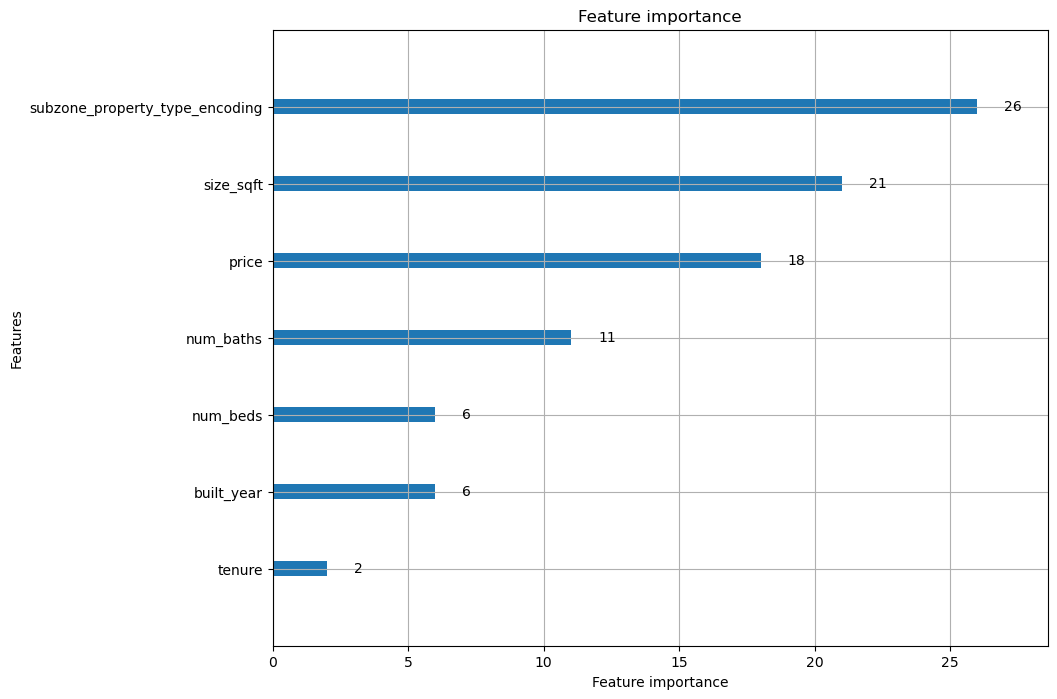

In [18]:
lgb.plot_importance(gbm_model, figsize = (10,8))